In [12]:
import pulp
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Define the problem
prob = pulp.LpProblem("BasicLP",pulp.LpMinimize)
# Variables
x1 = pulp.LpVariable("x1",0,None)
x2 = pulp.LpVariable("x2",0,None)
# Constraints
prob += 4*x1 + 1*x2 >= 8
prob += 1*x1 + 1*x2 >= 4
prob += 1*x1 + 8*x2 >= 8
prob += x1 + x2 <= 10
# Objectives
def f1(x1,x2):
    return 10*x1 + 1*x2
def f2(x1,x2):
    return 1*x1 + 10*x2
def F(alpha):
    return alpha*f1(x1,x2) + (1-alpha)*f2(x1,x2)

# Solve the problem for different values of lambda
alphas = np.linspace(0,1,10)
solutions = []
for alpha in alphas:
    prob += F(alpha)
    prob.solve()
    solutions.append([x1.varValue,x2.varValue])
solutions = np.unique(solutions, axis=0).tolist()

number_of_solutions = len(solutions)
solution_dict = {f'S{i+1}': solutions[i] for i in range(number_of_solutions)}
print(solution_dict)

{'S1': [0.0, 8.0], 'S2': [1.3333333, 2.6666667], 'S3': [3.4285714, 0.57142857], 'S4': [8.0, 0.0]}


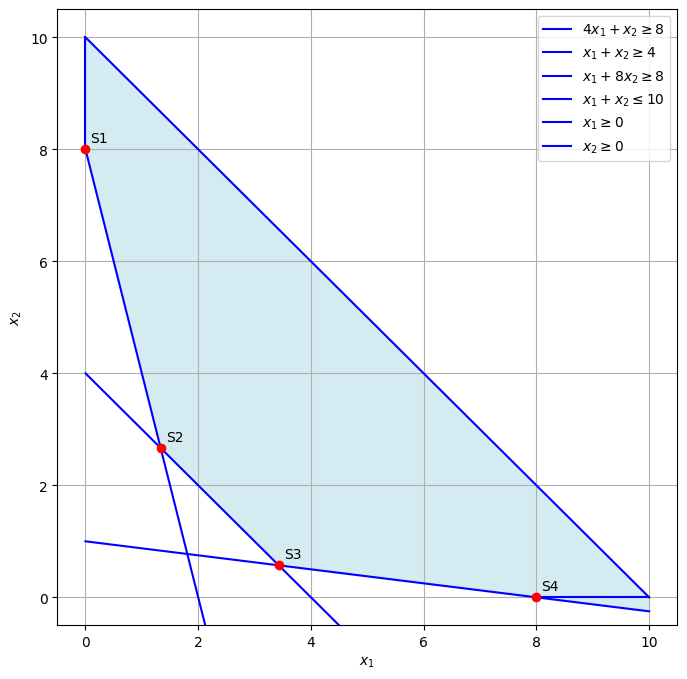

In [28]:
# Representing the LP on the decision space
# Define the range for x1
x1 = np.linspace(0, 10, 400)

# Define the constraints as functions of x1
x2_1 = (8 - 4*x1) / 1
x2_2 = 4 - x1
x2_3 = (8 - 1*x1) / 8
x2_4 = 10 - x1

# Create the plot
plt.figure(figsize=(8, 8))
plt.plot(x1, x2_1, 'b', label=r'$4x_1 + x_2 \geq 8$')
plt.plot(x1, x2_2, 'b', label=r'$x_1 + x_2 \geq 4$')
plt.plot(x1, x2_3, 'b', label=r'$x_1 + 8x_2 \geq 8$')
plt.plot(x1, x2_4, 'b', label=r'$x_1 + x_2 \leq 10$')

# Add the restriction lines for x1 >= 0 and x2 >= 0 within the feasible region
plt.plot([0, 0], [8, 10], 'b', label=r'$x_1 \geq 0$')
plt.plot([8, 10], [0, 0], 'b', label=r'$x_2 \geq 0$')

# Fill the feasible region
plt.fill_between(x1, np.maximum.reduce([x2_1, x2_2, x2_3]), x2_4, where=(x1 + x2_4 <= 10), color='lightblue', alpha=0.5)

# Plot the solutions
for key, value in solution_dict.items():
    plt.scatter(value[0], value[1], color='red', zorder=5)
    plt.annotate(key, (value[0], value[1]), textcoords="offset points", xytext=(10,5), ha='center')

# Set the limits for x and y axes
plt.xlim(-0.5, 10.5)
plt.ylim(-0.5, 10.5)

# Add labels and legend
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range for x1
x1 = np.linspace(0, 10, 400)

# Define the constraints as functions of x1
x2_1 = (8 - 4*x1) / 1
x2_2 = 4 - x1
x2_3 = (8 - 1*x1) / 8
x2_4 = 10 - x1

# Create the plot
plt.figure(figsize=(8, 8))
plt.plot(x1, x2_1, 'b', label=r'$4x_1 + x_2 \geq 8$')
plt.plot(x1, x2_2, 'b', label=r'$x_1 + x_2 \geq 4$')
plt.plot(x1, x2_3, 'b', label=r'$x_1 + 8x_2 \geq 8$')
plt.plot(x1, x2_4, 'b', label=r'$x_1 + x_2 \leq 10$')

# Fill the feasible region
plt.fill_between(x1, np.maximum.reduce([x2_1, x2_2, x2_3]), x2_4, where=(x1 + x2_4 <= 10), color='lightblue', alpha=0.5)

# Set the limits for x and y axes
plt.xlim(0, 10)
plt.ylim(0, 10)

# Add labels and legend
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()